In [561]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.simplefilter("ignore")

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn import metrics

## Preprocessing

In [640]:
data = pd.read_csv('/Users/katush/Documents/Otus/ML/L05-LinearReg/new-york-city-airbnb-open-data/AB_NYC_2019.csv')
skip = ['id', 'name', 'host_id', 'host_name', 'last_review']
data.drop(skip, axis=1, inplace=True)

In [641]:
print(data[data['price']==0].shape)
data = data[data['price']!=0]

(11, 11)


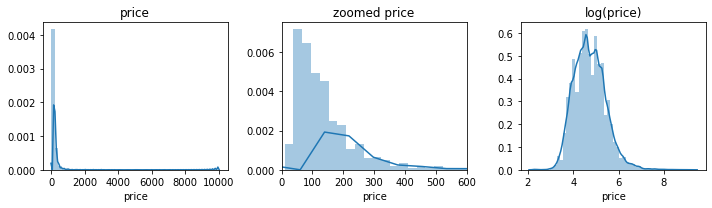

In [642]:
fig = plt.figure(figsize=(10, 3))

plt.subplot(131)
sns.distplot(data['price'])
plt.title('price')

plt.subplot(132)
sns.distplot(data.price, bins=350)
plt.xlim((0, 600))
plt.title('zoomed price')

plt.subplot(133)
sns.distplot(np.log(data['price']))
plt.title('log(price)')

plt.tight_layout()

log_cols = ['price']

In [643]:
cpark = (40.7851, -73.9683)
data['center_distance'] = np.sqrt((data['latitude'] - cpark[0])**2 + (data['longitude'] - cpark[1])**2)
data.drop(['latitude', 'longitude'], axis=1, inplace=True)
features = [i for i in data.columns if i != 'price']

In [644]:
num_cols = [i for i in features if data[i].dtype!='O']
print(num_cols)

['minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365', 'center_distance']


,column,nans,zeros
0,minimum_nights,0,0
1,number_of_reviews,0,10051
2,reviews_per_month,10051,0
3,calculated_host_listings_count,0,0
4,availability_365,0,17530
5,center_distance,0,0


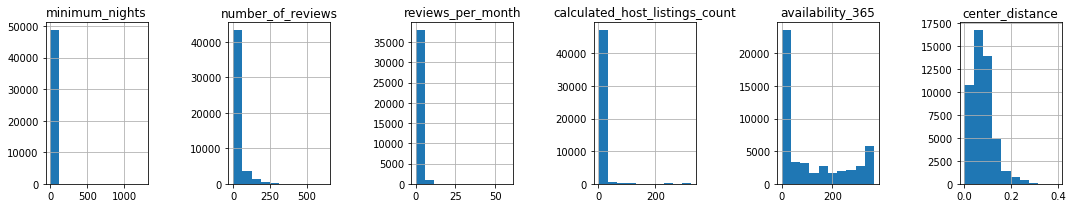

In [645]:
check = []
fig = plt.figure(figsize=(15, 3))
for ix, col in enumerate(num_cols):
    plt.subplot(1, len(num_cols), (ix+1))
    data[col].hist()
    plt.title(col)
    check.append([col, data[data[col].isna()].shape[0], data[data[col]==0].shape[0]])
plt.tight_layout()
check = pd.DataFrame(check, columns=['column', 'nans', 'zeros'])
check

In [646]:
print(data[data['number_of_reviews']==0]['reviews_per_month'].unique())
print(data[data['reviews_per_month'].isna()]['number_of_reviews'].unique())
data['reviews_per_month'].fillna(0, inplace=True)

[nan]
[0]


In [647]:
# log_cols = log_cols + ['minimum_nights', 'calculated_host_listings_count', 'center_distance']
log_cols = ['minimum_nights', 'calculated_host_listings_count', 'center_distance']

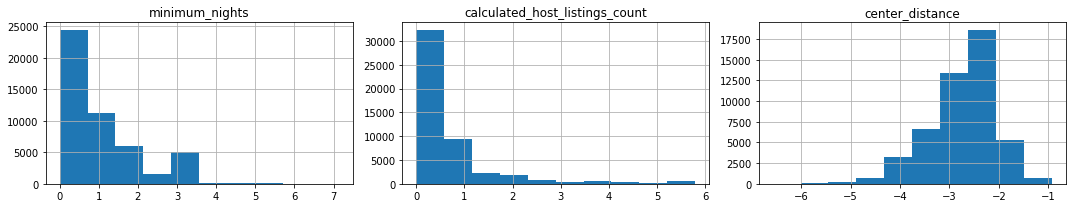

In [648]:
fig = plt.figure(figsize=(15, 3))
for ix, col in enumerate(log_cols):
    plt.subplot(1, len(log_cols), (ix+1))
    np.log(data[col]).hist()
    plt.title(col)
plt.tight_layout()

In [649]:
for i in log_cols:
    data[i] = np.log(data[i])
    print(f'max({i})', data[i].max())

max(minimum_nights) 7.1308988302963465
max(calculated_host_listings_count) 5.7899601708972535
max(center_distance) -0.9299768194168561


In [650]:
obj_cols = [i for i in features if data[i].dtype=='O']
print(obj_cols)

for col in obj_cols:
    names = dict(zip(data[col].unique(), [col+': '+i for i in data[col].unique()]))
    data = data.join(pd.get_dummies(data[col], drop_first=True).rename(columns=names)).drop(col, axis=1)

['neighbourhood_group', 'neighbourhood', 'room_type']


In [636]:
# def corr_feature_detect(data, threshold=0.8):
    
#     corrmat = data.drop(['price'], axis=1).corr()

#     corrmat = corrmat.abs().unstack().sort_values(ascending=False)

#     corrmat = corrmat[corrmat >= threshold]
#     corrmat = corrmat[corrmat < 1]

#     corrmat = pd.DataFrame(corrmat).reset_index()
#     corrmat.columns = ['feature1', 'feature2', 'corr']
   
#     correlated_feats = []

#     for row in corrmat.values:
#         f1, f2, corr_value = row

#         if not ((f1 in correlated_feats) | (f2 in correlated_feats)):
#             f1_feat_len = corrmat[(corrmat.feature1==f1) | (corrmat.feature2==f1)].shape[0]
#             f2_feat_len = corrmat[(corrmat.feature1==f2) | (corrmat.feature2==f2)].shape[0]

#             if f1_feat_len >= f2_feat_len:
#                 correlated_feats.append(f1)
#             else:
#                 correlated_feats.append(f2)
    
#     return correlated_feats

# data_num_corr_features = corr_feature_detect(data, threshold=0.5)
# print(data_num_corr_features)

['neighbourhood_group: Brooklyn', 'center_distance', 'reviews_per_month']


In [608]:
# data = data.drop(data_num_corr_features, axis=1)

In [651]:
X = data.drop('price', axis=1)
y = data['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

y_train_log = np.log(y_train)
y_test_log = np.log(y_test)

In [653]:
scaler = MinMaxScaler()
# scaler.fit(X_train)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train.max().max(), X_test.max().max(), X_train_scaled.max().max(), X_test_scaled.max().max()

(607.0, 629.0, 1.0, 1.0362438220757826)

## Metrics

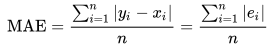

The root-mean-square deviation (RMSD) or root-mean-square error (RMSE)
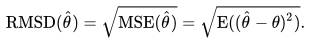

The coefficient of determination is the proportion of the variance in the dependent variable that is predictable from the independent variable(s)
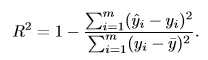

The mean absolute percentage error (MAPE), also known as mean absolute percentage deviation (MAPD), is a measure of prediction accuracy ($A_{t}$ is the actual value and $F_{t}$ is the forecast value):
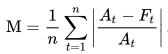

In [740]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def dataframe_metrics(y_test,y_pred):    
    
    stats = [
       metrics.mean_absolute_error(y_test, y_pred),
       np.sqrt(metrics.mean_squared_error(y_test, y_pred)),
       metrics.r2_score(y_test, y_pred),
       mean_absolute_percentage_error(y_test, y_pred)
    ]
    return stats
measured_metrics = pd.DataFrame({"error_type":["MAE", "RMSE", "R2", "MAPE"]})
measured_metrics.set_index("error_type", inplace=True)

## Linear Regression

In [756]:
model = LinearRegression()
model.fit(X_train_scaled, y_train_log)

y_pred_log = model.predict(X_test_scaled)
y_pred = np.exp(y_pred_log)

In [757]:
print('y_pred_log vs y_pred: ', y_pred_log.max(), y_pred.max())
print('y_test vs y_pred: ', y_test.max(), y_pred.max(), '\n')
print(*list(zip(y_test[:5], y_preds[:5])), sep='\n')

y_pred_log vs y_pred:  4761912825.95999 inf
y_test vs y_pred:  8000 inf 

(99, 93.79330406194845)
(90, 83.3254420760469)
(80, 142.4715494566526)
(60, 62.42692079924835)
(90, 91.05891150242279)


In [ ]:
# measured_metrics["LinReg"] = dataframe_metrics(y_test, y_preds)

## RidgeCV,  LassoCV,  ElasticNetCV

RidgeCV 

y_pred_log vs y_pred:  6.259789314422965 523.1087170353018
y_test vs y_pred:  8000 523.1087170353018 

(99, 93.79330406194845)
(90, 83.3254420760469)
(80, 142.4715494566526)
(60, 62.42692079924835)
(90, 91.05891150242279)
LassoCV 

y_pred_log vs y_pred:  6.251028493389005 518.5458715045187
y_test vs y_pred:  8000 518.5458715045187 

(99, 93.79330406194845)
(90, 83.3254420760469)
(80, 142.4715494566526)
(60, 62.42692079924835)
(90, 91.05891150242279)
ElasticNetCV 

y_pred_log vs y_pred:  6.2134449703572905 499.41877405318155
y_test vs y_pred:  8000 499.41877405318155 

(99, 93.79330406194845)
(90, 83.3254420760469)
(80, 142.4715494566526)
(60, 62.42692079924835)
(90, 91.05891150242279)


,RidgeCV,LassoCV,ElasticNetCV
error_type,,,
MAE,58.221533,58.290856,58.280690
RMSE,180.728605,180.894918,180.993782
R2,0.144672,0.143097,0.142160
MAPE,34.579414,34.657918,34.655964


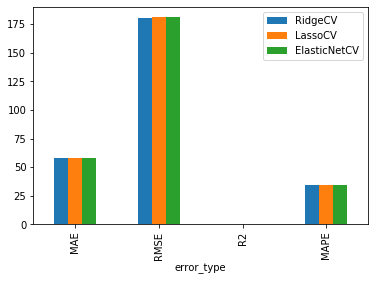

In [755]:
algs = {'RidgeCV': RidgeCV(), 'LassoCV': LassoCV(), 'ElasticNetCV': ElasticNetCV()}
for name, alg in algs.items():
    model = alg
    model.fit(X_train_scaled, y_train_log)

    y_pred_log = model.predict(X_test_scaled)
    y_pred = np.exp(y_pred_log)
    
    measured_metrics[name] = dataframe_metrics(y_test, y_pred)
    
    print(name, '\n')
    print('y_pred_log vs y_pred: ', y_pred_log.max(), y_pred.max())
    print('y_test vs y_pred: ', y_test.max(), y_pred.max(), '\n')
    print(*list(zip(y_test[:5], y_preds[:5])), sep='\n')
    
measured_metrics.plot(kind='bar')
measured_metrics

Без использования регуляризации линейная регрессия для предсказания выдает слишком большое значение - вероятно это связано с корреляцией в данных.
<br><br>Если использовать регуляризацию (RidgeCV, LassoCV, ElasticNetCV), модель предсказывает более адекватные значения, причем метрики (MAE, RMSE, R2, MAPE) имеют доволльно схожие значения.
<br><br>Таким образом предсказание цены возможно только с использованием регуляризации с качеством:
- MAE = 58,22
- RMSE =  180,73
- R2 = 0,15
- MAPE = 34,58